In [226]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from pandas import read_parquet, DataFrame, Series, concat, merge, to_numeric
from data import file
from tqdm import tqdm
from preprocessing.categorical import binarizer
import numpy as np
from datetime import datetime

In [29]:
# apply progress bar on pandas operations
tqdm.pandas()

In [30]:
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

In [31]:
data_train = read_parquet(file.news_articles_cleaned_train)
data_test = read_parquet(file.news_articles_cleaned_test)
data_val = read_parquet(file.news_articles_cleaned_val)

In [33]:
print("train size:", data_train.shape, "categories:", len(data_train.label.unique()))
print("test size :", data_test.shape, "categories:", len(data_test.label.unique()))
print("val size  :", data_val.shape, "categories:", len(data_val.label.unique()))

train size: (7191, 9) categories: 9
test size : (2054, 9) categories: 9
val size  : (1028, 9) categories: 9


In [34]:
MAXLEN = 192

def tokenize(review):

  encoded = tokenizer.encode_plus(
      text=review,
      add_special_tokens=True,     # Add `[CLS]` and `[SEP]`
      max_length=MAXLEN,           # Max length to truncate/pad
      padding='max_length',        # Pad sentence to max length
      return_attention_mask=False, # attention mask not needed for our task
      return_token_type_ids=False,
      truncation=True)
  return encoded['input_ids']

In [35]:
data_hf_tokenized_train = concat([data_train, data_train.text_original.progress_map(tokenize).rename('hf_tokenized')], axis=1)
data_hf_tokenized_train.to_parquet(path=file.news_articles_hf_tokenized_train)

100%|██████████| 7191/7191 [00:52<00:00, 135.87it/s]


In [36]:
data_hf_tokenized_test = concat([data_test, data_test.text_original.progress_map(tokenize).rename('hf_tokenized')], axis=1)
data_hf_tokenized_test.to_parquet(path=file.news_articles_hf_tokenized_test)

100%|██████████| 2054/2054 [00:15<00:00, 131.58it/s]


In [37]:
data_hf_tokenized_val = concat([data_val, data_val.text_original.progress_map(tokenize).rename('hf_tokenized')], axis=1)
data_hf_tokenized_val.to_parquet(path=file.news_articles_hf_tokenized_val)

100%|██████████| 1028/1028 [00:07<00:00, 131.21it/s]


In [41]:
hf_data_train = read_parquet(file.news_articles_hf_tokenized_train)
hf_data_test = read_parquet(file.news_articles_hf_tokenized_test)
hf_data_val = read_parquet(file.news_articles_hf_tokenized_val)

print("train size:", hf_data_train.shape, "categories:", len(hf_data_train.label.unique()))
print("test size :", hf_data_test.shape, "categories:", len(hf_data_test.label.unique()))
print("val size  :", hf_data_val.shape, "categories:", len(hf_data_val.label.unique()))

train size: (7191, 10) categories: 9
test size : (2054, 10) categories: 9
val size  : (1028, 10) categories: 9


In [52]:
label_binarizer=binarizer(hf_data_train.label)
label_bin_train = label_binarizer.transform(hf_data_train.label)
label_bin_test = label_binarizer.transform(hf_data_test.label)

print("train label size:", label_bin_train.shape, "categories:", len(hf_data_train.label.unique()))
print("test label size :", label_bin_test.shape, "categories:", len(hf_data_test.label.unique()))

train label size: (7191, 9) categories: 9
test label size : (2054, 9) categories: 9


In [152]:
BATCH_SIZE = 16
EPOCHS = 8
LEARNING_RATE = 1e-5

train_dataset = (tf.data.Dataset.from_tensor_slices((hf_data_train.hf_tokenized.map(lambda x:x.tolist()).tolist(), label_bin_train))
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

test_dataset = (tf.data.Dataset.from_tensor_slices((hf_data_test.hf_tokenized.map(lambda x:x.tolist()).tolist(), label_bin_test))
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))


In [147]:
def build_model(output_classes, max_len=MAXLEN):
    """ add binary classification to pretrained model
    """

    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )

    bert_model = TFBertModel.from_pretrained("bert-base-german-cased")
    encoder_outputs = bert_model(input_word_ids)

    pooler_output = encoder_outputs[1]
    cls_embedding = pooler_output

    stack = tf.keras.layers.Dense(output_classes)(cls_embedding)
    output = tf.keras.layers.Activation('softmax')(stack)

    ##########################
    ## YOUR CODE HERE END ##
    ##########################

    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)
    
    return model


In [149]:
model = build_model(len(data_train.label.unique()), max_len=MAXLEN)
model.summary()

Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_bert_model_2 (TFBertModel TFBaseModelOutputWithPool 109081344 
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 6921      
_________________________________________________________________
activation_1 (Activation)    (None, 9)                 0         
Total params: 109,088,265
Trainable params: 109,088,265
Non-trainable params: 0
_________________________________________________________________


In [151]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = loss="binary_crossentropy"

model.compile(optimizer, loss=loss, metrics=["accuracy"])

In [162]:
hist = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=int(np.floor((len(hf_data_train) / BATCH_SIZE))),
    validation_data=test_dataset,
    verbose=1,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=1, restore_best_weights=True),
               tf.keras.callbacks.TensorBoard(f'logs/{datetime.now()}')
               ],
)

2021-11-18 03:13:21.841382: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-18 03:13:21.841453: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-18 03:13:21.843414: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs


2021-11-18 03:13:22.055247: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-18 03:13:22.055523: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/8


2021-11-18 03:13:31.996048: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


  1/449 [..............................] - ETA: 1:41:48 - loss: 0.8372 - accuracy: 0.1250

2021-11-18 03:13:36.235612: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-18 03:13:36.235663: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/449 [..............................] - ETA: 9:03 - loss: 0.8085 - accuracy: 0.1562   

2021-11-18 03:13:37.085122: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-18 03:13:37.088283: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-11-18 03:13:37.250628: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 3002 callback api events and 2999 activity events. 
2021-11-18 03:13:37.322504: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-18 03:13:37.434825: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/2021-11-18 03:13:21.838630/train/plugins/profile/2021_11_18_03_13_37

2021-11-18 03:13:37.492466: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/2021-11-18 03:13:21.838630/train/plugins/profile/2021_11_18_03_13_37/frankfurt-tf-26-cpu-2-gpu-1.trace.json.gz
2021-11-18 03:13:37.622614: I tensorflow/core/profi

449/449 [==============================] - 349s 749ms/step - loss: 0.1465 - accuracy: 0.7666 - val_loss: 0.0774 - val_accuracy: 0.8749
Epoch 2/8
449/449 [==============================] - 29s 64ms/step - loss: 0.1105 - accuracy: 0.7143 - val_loss: 0.0782 - val_accuracy: 0.8768
Restoring model weights from the end of the best epoch.
Epoch 00002: early stopping


In [258]:
sample = data_hf_tokenized_val[0:100]
y_predict = label_binarizer.inverse_transform(model.predict(sample.hf_tokenized.tolist()))

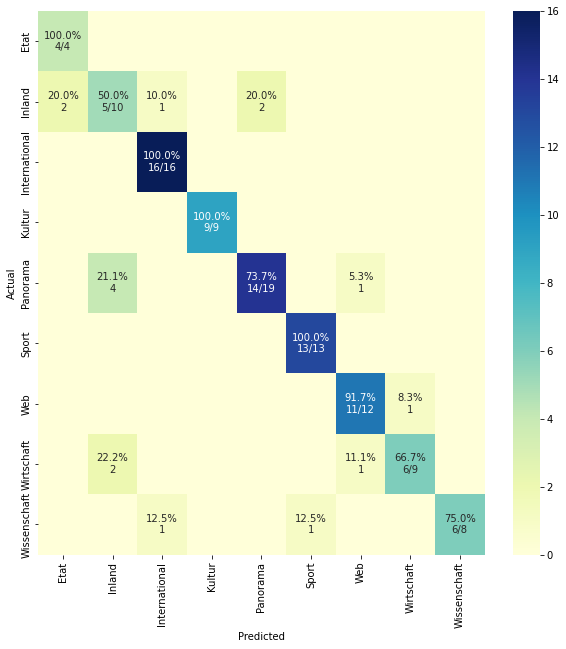

In [259]:
from reporting.evaluation import plot_confusion_matrix
plot_confusion_matrix(sample.label, y_predict)

In [255]:
prediction = Series(y_predict).rename("prediction").to_frame().set_index(sample.index)
concat([sample, prediction], axis=1)

,text_original,label,text_tokenized,text_tokenized_keywords,text_keywords,text_tokenized_lemmas,text_lemmas,text_tokenized_stemmed,text_stem,hf_tokenized,prediction
9073,"1556 – Der Erzbischof von Canterbury, Thomas C...",Wissenschaft,"[1556, –, der, erzbischof, von, canterbury, ,,...","[1556, –, erzbischof, canterbury, ,, thomas, c...","1556 – erzbischof canterbury , thomas cranmer ...","[1556, erzbischof, canterbury, thomas, cranmer...",1556 erzbischof canterbury thomas cranmer oxfo...,"[1556, erzbischof, canterbury, thomas, cranm, ...",1556 erzbischof canterbury thomas cranm oxford...,"[3, 19041, 26960, 2, 233, 9443, 88, 21447, 756...",International
8537,Gemma Bundesheer schauen! Nationalfeiertag auf...,Inland,"[gemma, bundesheer, schauen, !, nationalfeiert...","[gemma, bundesheer, schauen, !, nationalfeiert...",gemma bundesheer schauen ! nationalfeiertag he...,"[gemma, bundesheer, schauen, nationalfeiertag,...",gemma bundesheer schauen nationalfeiertag held...,"[gemma, bundeshe, schau, nationalfeiertag, hel...",gemma bundeshe schau nationalfeiertag heldenpl...,"[3, 610, 751, 578, 14986, 17036, 26982, 1921, ...",Panorama
4544,Am Montag wurde Insolvenz angemeldet. Georg Pf...,Wirtschaft,"[am, montag, wurde, insolvenz, angemeldet, ., ...","[montag, wurde, insolvenz, angemeldet, ., geor...",montag wurde insolvenz angemeldet . georg pfei...,"[montag, werden, insolvenz, anmelden, georg, p...",montag werden insolvenz anmelden georg pfeiffe...,"[montag, wurd, insolvenz, angemeldet, georg, p...",montag wurd insolvenz angemeldet georg pfeiff ...,"[3, 570, 4141, 192, 4461, 20095, 26914, 3578, ...",Wirtschaft
1547,Drei Fragen in zweifelhafter Nachrichtenumgebu...,Inland,"[drei, fragen, in, zweifelhafter, nachrichtenu...","[drei, fragen, zweifelhafter, nachrichtenumgeb...",drei fragen zweifelhafter nachrichtenumgebung ...,"[drei, fragen, zweifelhaft, nachrichtenumgebun...",drei fragen zweifelhaft nachrichtenumgebung fp...,"[drei, frag, zweifelhaft, nachrichtenumgeb, fp...",drei frag zweifelhaft nachrichtenumgeb fpo-kan...,"[3, 2955, 4168, 50, 21618, 6, 4663, 107, 4209,...",Etat
1954,Wellenförmige Muster in Materiescheibe um AU M...,Wissenschaft,"[wellenförmige, muster, in, materiescheibe, um...","[wellenförmige, muster, materiescheibe, au, mi...",wellenförmige muster materiescheibe au microsc...,"[wellenförmige, muster, materiescheibe, au, mi...",wellenförmige muster materiescheibe au microsc...,"[wellenform, must, materiescheib, au, microsco...",wellenform must materiescheib au microscopii l...,"[3, 11855, 12998, 9719, 50, 26391, 16348, 259,...",Wissenschaft
...,...,...,...,...,...,...,...,...,...,...,...
372,Gewerkschaft fordert Anerkennung des Tarifvert...,Wirtschaft,"[gewerkschaft, fordert, anerkennung, des, tari...","[gewerkschaft, fordert, anerkennung, tarifvert...",gewerkschaft fordert anerkennung tarifvertrags...,"[gewerkschaft, fordern, anerkennung, tarifvert...",gewerkschaft fordern anerkennung tarifvertrags...,"[gewerkschaft, fordert, anerkenn, tarifvertrag...",gewerkschaft fordert anerkenn tarifvertrag ein...,"[3, 12036, 8559, 7259, 91, 10015, 26902, 142, ...",Wirtschaft
7066,Täglich 510 Millionen Exemplare verteilt – Imm...,Etat,"[täglich, 510, millionen, exemplare, verteilt,...","[täglich, 510, millionen, exemplare, verteilt,...",täglich 510 millionen exemplare verteilt – imm...,"[täglich, 510, millionen, exemplare, verteilen...",täglich 510 millionen exemplare verteilen imme...,"[taglich, 510, million, exemplar, verteilt, im...",taglich 510 million exemplar verteilt imm mehr...,"[3, 15697, 490, 8858, 26928, 1483, 12674, 9739...",Etat
3785,"Führungen, Lesungen, Konzert und offenes Ateli...",Kultur,"[führungen, ,, lesungen, ,, konzert, und, offe...","[führungen, ,, lesungen, ,, konzert, offenes, ...","führungen , lesungen , konzert offenes atelier...","[führungen, lesungen, konzert, offen, atelier,...",führungen lesungen konzert offen atelier 24. 3...,"[fuhrung, lesung, konzert, off, ateli, 24., 30...",fuhrung lesung konze